In [1]:
from typing import TypedDict, Annotated
from langgraph.graph import add_messages, StateGraph, END
# from langchain_groq import ChatGroq
from langchain_core.messages import AIMessage, HumanMessage
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode
from ourLLM import create_azure_openai_model

load_dotenv()

class ChildState(TypedDict):
    messages: Annotated[list, add_messages]

search_tool = TavilySearchResults(max_results=2)
tools = [search_tool]

llm = create_azure_openai_model()

llm_with_tools = llm.bind_tools(tools=tools)

def agent(state: ChildState):
    return {
        "messages": [llm_with_tools.invoke(state["messages"])], 
    }

def tools_router(state: ChildState):
    last_message = state["messages"][-1]

    if(hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0):
        return "tool_node"
    else: 
        return END
    

tool_node = ToolNode(tools=tools)

subgraph = StateGraph(ChildState)

subgraph.add_node("agent", agent)
subgraph.add_node("tool_node", tool_node)
subgraph.set_entry_point("agent")

subgraph.add_conditional_edges("agent", tools_router)
subgraph.add_edge("tool_node", "agent")

search_app = subgraph.compile()

/var/folders/nm/5cckxsbx0yl9wzynfv0qzsxc0000gn/T/ipykernel_68358/223808856.py:15: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search_tool = TavilySearchResults(max_results=2)


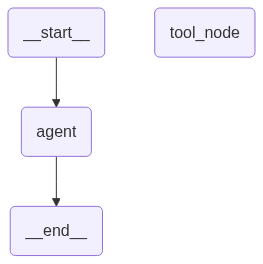

In [2]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        search_app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [3]:
search_app.invoke({"messages": [HumanMessage(content="How is the weather in Chennai?")]})

{'messages': [HumanMessage(content='How is the weather in Chennai?', additional_kwargs={}, response_metadata={}, id='ef9a131f-8d4b-4680-8fff-05fbf2f2492c'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_VW772HbMboWPUhQSL4XQ8sIn', 'function': {'arguments': '{"query":"Chennai weather"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 86, 'total_tokens': 107, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_efad92c60b', 'id': 'chatcmpl-BwoLHJUOeSbDhbzqs7h5LEeBPFzLI', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': Fals

Case 1: Shared Schema (Direct Embedding)

In [4]:
from typing import TypedDict, Annotated
from langgraph.graph import add_messages, StateGraph, START, END
from langchain_core.messages import HumanMessage

# Define parent graph with the same schema
class ParentState(TypedDict):
    messages: Annotated[list, add_messages]

# Create parent graph
parent_graph = StateGraph(ParentState)

# Add the subgraph as a node
parent_graph.add_node("search_agent", search_app)

# Connect the flow
parent_graph.add_edge(START, "search_agent")
parent_graph.add_edge("search_agent", END)

# Compile parent graph
parent_app = parent_graph.compile()

# Run the parent graph
result = parent_app.invoke({"messages": [HumanMessage(content="How is the weather in Chennai?")]})
result

{'messages': [HumanMessage(content='How is the weather in Chennai?', additional_kwargs={}, response_metadata={}, id='98de6fa5-fc24-4f90-abc0-164c75074fb6'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_9UA5pH1kzEQMijzhOhrmQ47O', 'function': {'arguments': '{"query":"current weather in Chennai"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 86, 'total_tokens': 108, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_efad92c60b', 'id': 'chatcmpl-BwoLO4VcH8z4QdNxfAfjHY6hZA4Sr', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filt

Case 2: Different Schema (Invoke with Transformation)

In [5]:
from typing import TypedDict, Annotated, Dict
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage

# Define parent graph with different schema
class QueryState(TypedDict):
    query: str
    response: str

# Function to invoke subgraph
def search_agent(state: QueryState) -> Dict:
    # Transform from parent schema to subgraph schema
    subgraph_input = {
        "messages": [HumanMessage(content=state["query"])]
    }
    
    # Invoke the subgraph
    subgraph_result = search_app.invoke(subgraph_input)
    
    # Transform response back to parent schema
    assistant_message = subgraph_result["messages"][-1]
    return {"response": assistant_message.content}

# Create parent graph
parent_graph = StateGraph(QueryState)

# Add transformation node that invokes subgraph
parent_graph.add_node("search_agent", search_agent)

# Connect the flow
parent_graph.add_edge(START, "search_agent")
parent_graph.add_edge("search_agent", END)

# Compile parent graph
parent_app = parent_graph.compile()

# Run the parent graph
result = parent_app.invoke({"query": "How is the weather in Chennai?", "response": ""})
print(result)

{'query': 'How is the weather in Chennai?', 'response': 'The current weather in Chennai is characterized by rainy intervals and breezy conditions. The temperatures are quite high, typically ranging between 28°C and 34°C. \n\nFor more details, you can check the full forecasts at [Times of India](https://timesofindia.indiatimes.com/weather/chennai-weather-forecast-today/600017) or [Weather25](https://www.weather25.com/asia/india/tamil-nadu/chennai?page=month&month=July).'}
